### **Data Installation & Setup**

Upload the kaggle api token file

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aishwaryamenon15","key":"059532ade2144fde97eb970bd1f9bdd7"}'}

Install the Kaggle API Client

In [2]:
# -q means quiet installation
# !pip install -q Kaggle

In [3]:
# The Kaggle API Client expects the file to be in the .kaggle directory
# -p option creates a parent directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# chmod 600: Owner gets read write permissions
!chmod 600 ~/.kaggle/kaggle.json

Setup a directory to store the data

In [4]:
# Remember, !cd and %cd are 2 different commands in IPython shell
!mkdir dog_dataset
%cd dog_dataset

mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


Searching for the required dataset in the kaggle database

In [5]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           5929          8  0.1764706        


Download the dataset

In [6]:
# Use the ref id and download the data in the current working directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp

# Return back to the main dir
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 97% 673M/691M [00:05<00:00, 180MB/s]
100% 691M/691M [00:05<00:00, 130MB/s]
/content


Unzip it and remove all unrelevent files

In [7]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Archive:  dog_dataset/dogbreedidfromcomp.zip
replace dog_dataset/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: dog_dataset/sample_submission.csv  
replace dog_dataset/test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dog_dataset/test/00102ee9d8eb90812350685311fe5890.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dog_dataset/test/0012a730dfa437f5f3613fb75efcd4ce.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dog_dataset/test/0012a730dfa437f5f3613fb75efcd4ce.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Import Required Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [9]:
labels = pd.read_csv("dog_dataset/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Data Processing

In [10]:
labels.shape

(10222, 2)

In [11]:
labels["breed"].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

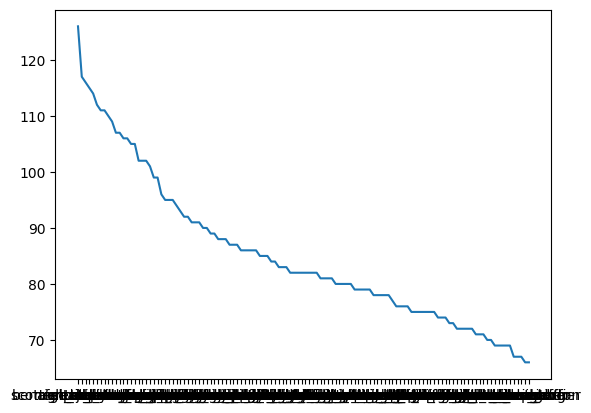

In [12]:
plt.plot(labels["breed"].value_counts())

In [13]:
# Let's consider only 3 breed classes (to simplify the problem)
BREEDS = list(labels["breed"].value_counts().keys()[:3])
labels = labels[labels["breed"].isin(BREEDS)]
labels = labels.reset_index()
print(labels.shape)
labels.head()

(359, 3)


,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


In [14]:
labels.drop("index", axis=1, inplace=True)

In [15]:
labels.isna().sum()

id       0
breed    0
dtype: int64

In [16]:
# Creating numpy matrix with zeros
X_train_data = np.zeros((len(labels), 224, 224, 3),dtype="float32")

# One hot encoding on the labels
Y_train_data = label_binarize(labels['breed'], classes=BREEDS)

In [17]:
# Reading and converting image to numpy array and normalizing the dataset
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' %labels['id'][i], target_size=(224, 224))
  img = image.img_to_array(img)
  X_train_data[i] = img / 255.0

100%|██████████| 359/359 [00:02<00:00, 164.81it/s]


In [18]:
# Printing the final shape and size of the images and the target value
print('\nTain Images shape:', X_train_data.shape, ' size:', X_train_data.size)
print('OHE output shape:', Y_train_data.shape, ' size:', Y_train_data.size)


Tain Images shape: (359, 224, 224, 3)  size: 54039552
OHE output shape: (359, 3)  size: 1077


### Model Building

In [19]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(7,7), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=8, kernel_size=(5,5), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(len(BREEDS), activation='softmax'))

In [20]:
# Model Compilation
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 16)        0

In [21]:
# Splitting the data into train, test and val sets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_train_data, Y_train_data, test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.2)

### Model Training